In [0]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models 
import torch
import numpy as np 
import os.path
import numpy as np 
import torch.optim as optim
#from sklearn.pipeline import Pipeline


In [0]:
n_epochs = 100
batch_size = 128
lr = 0.001
k = 3

In [0]:
project_path = '/content/drive/My Drive/Colab Notebooks/'#'include pathe to where your notebook is located on the drive'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
# download CIFAR 10 training set
trainset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True,
                                        download=True, transform=transform_train)

# load the trainning set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# download the test data
testset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True,
                                        download=False, transform=transform_test)

# load the test data
testloader =torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# check those manually on the dataset site: https://www.cs.toronto.edu/~kriz/cifar.html 

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer  deer  ship   dog


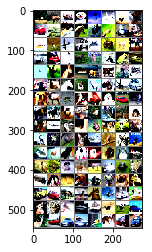

In [6]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 

# notice who we converted the class idx to labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# run this cell multiple times and notice diff images

In [0]:
# divide the training dataset into the required groups Make sure they are balanced
# original trainset is made of 50k images

total_size = len(trainset)
split1 = total_size // 4
split2 = split1 * 2
split3 = split1 * 3

indices = list(range(total_size))

# two groups to train the shadow (in and out)
shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

# two groups to train the Target (in and out)
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]


In [0]:
# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx) 
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_out_sampler)




---



In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Model Definition

In [0]:
class NetT(nn.Module): 
    def __init__(self, n_in=3, n_out=10, n_hidden=64, size=32): 
        super(NetT, self).__init__()
        
        self.n_hidden = n_hidden 
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(n_in, n_hidden, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(n_hidden), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(n_hidden, 2*n_hidden, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(2*n_hidden), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 

        self.fc = nn.Linear(int(2*n_hidden * 16*4), 128)
        self.output = nn.Linear(2*n_hidden, n_out)
        
    def forward(self, x): 
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        out = self.output(x)
        
        return out
def weights_init(m): 
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear): 
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias, 0)
class NetA(nn.Module): 
    def __init__(self, n_in=3, n_out=1, n_hidden=64): 
        super(NetA, self).__init__()
        
        self.hidden = nn.Linear(n_in, n_hidden)
        self.output = nn.Linear(n_hidden, n_out)
        
    def forward(self, x): 
        x = torch.sigmoid(self.hidden(x))
        out = self.output(x)
        out = self.output(x)
        
        return out
target_net_type = NetT
shadow_net_type = NetT   

target_net = target_net_type().to(device)
target_net.apply(weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)


shadow_net = shadow_net_type().to(device)
shadow_net.apply(weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)

attack_net = NetA().to(device)
attack_net.apply(weights_init)

attack_loss = nn.BCEWithLogitsLoss()
attack_optim = optim.Adam(attack_net.parameters(), lr=lr)

            

#Train Shadow Model


[0/100]


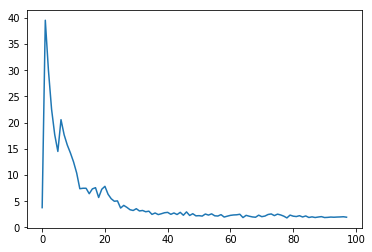

[1/100]


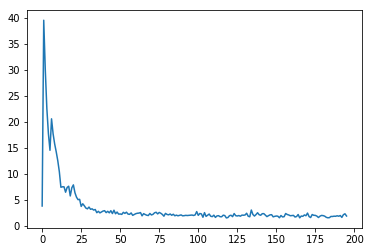

[2/100]


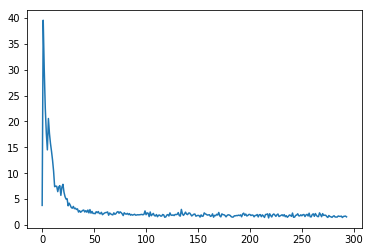

[3/100]


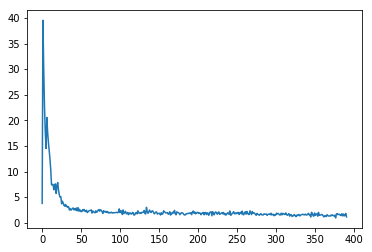

[4/100]


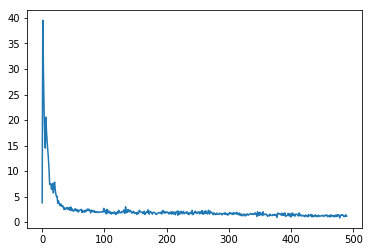

[5/100]


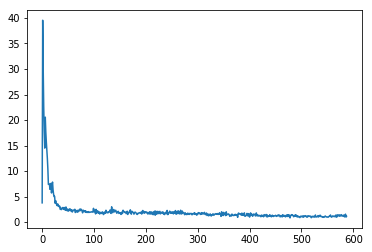

[6/100]


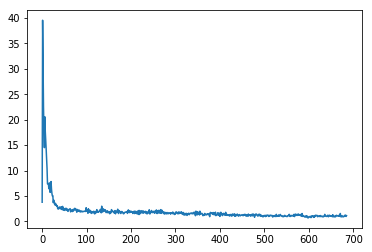

[7/100]


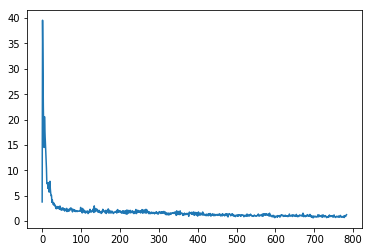

[8/100]


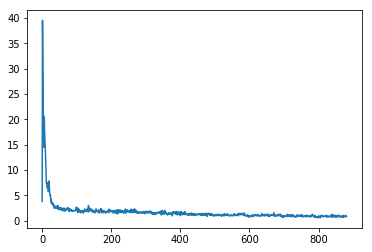

[9/100]


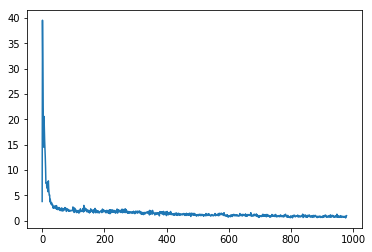

[10/100]


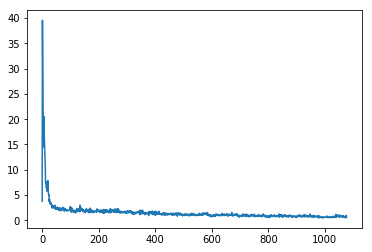

[11/100]


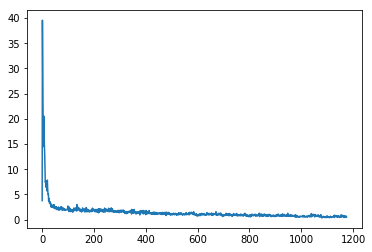

[12/100]


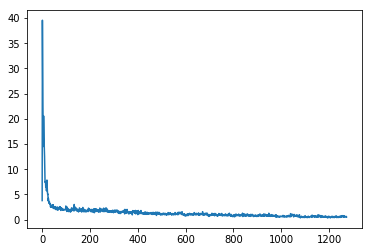

[13/100]


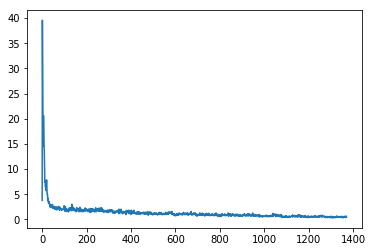

[14/100]


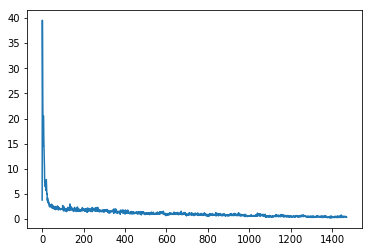

[15/100]


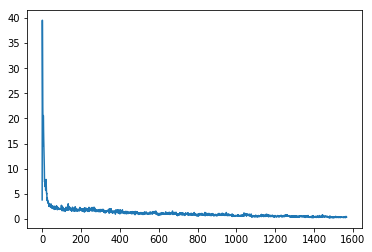

[16/100]


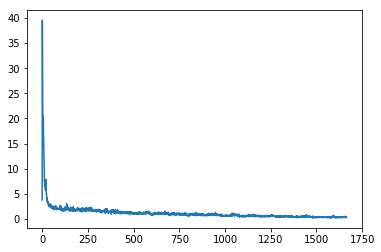

[17/100]


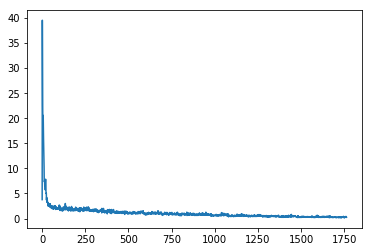

[18/100]


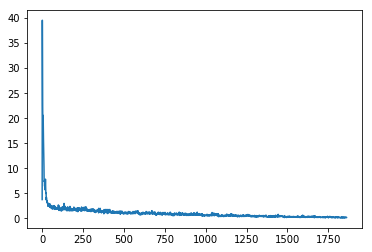

[19/100]


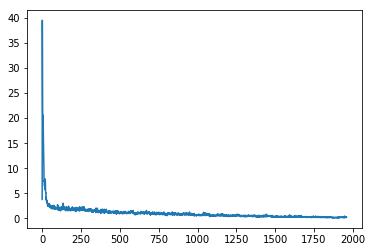

[20/100]


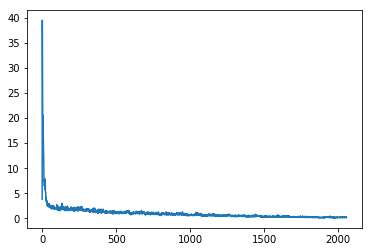

[21/100]


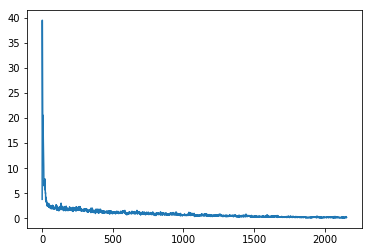

[22/100]


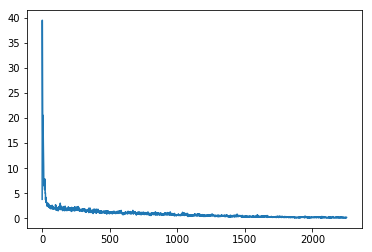

[23/100]


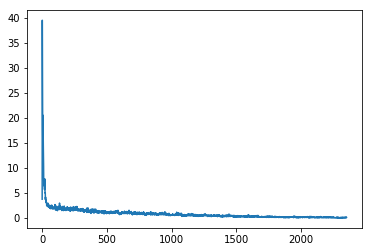

[24/100]


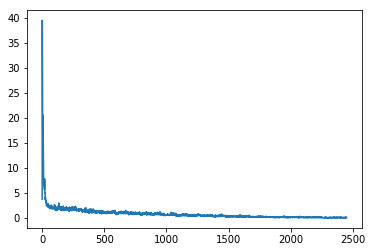

[25/100]


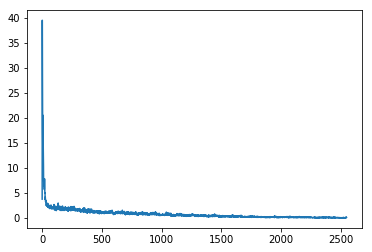

[26/100]


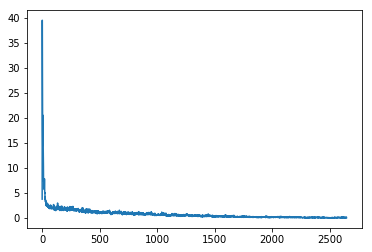

[27/100]


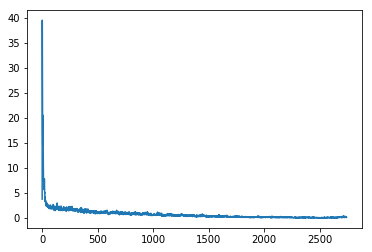

[28/100]


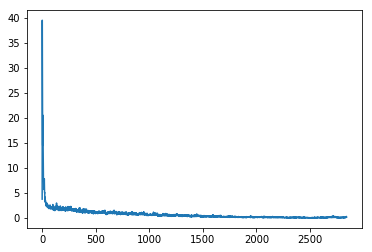

[29/100]


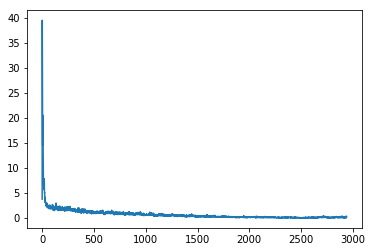

[30/100]


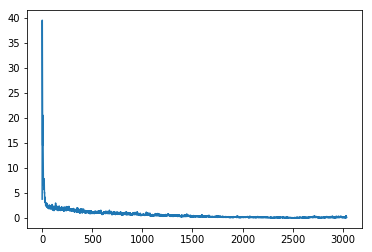

[31/100]


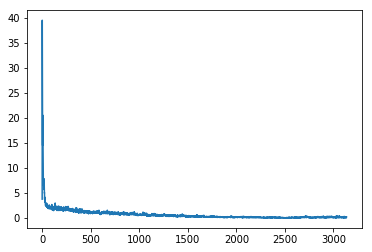

[32/100]


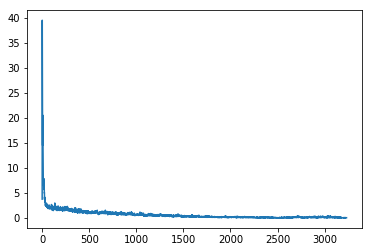

[33/100]


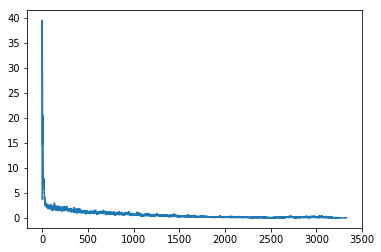

[34/100]


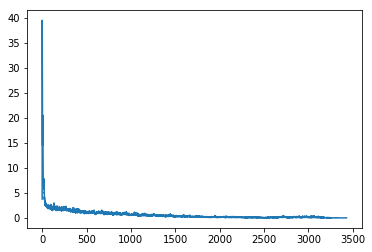

[35/100]


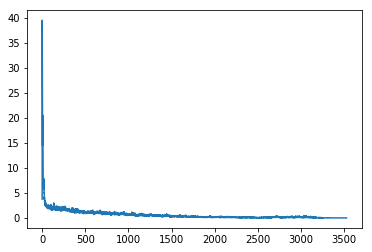

[36/100]


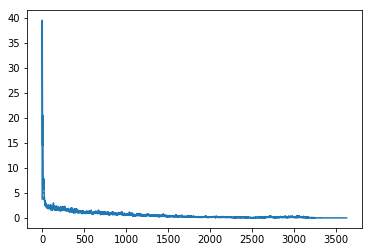

[37/100]


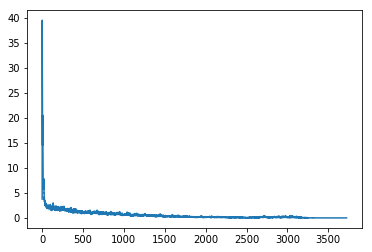

[38/100]


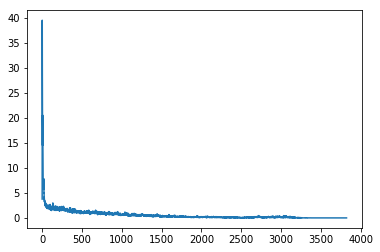

[39/100]


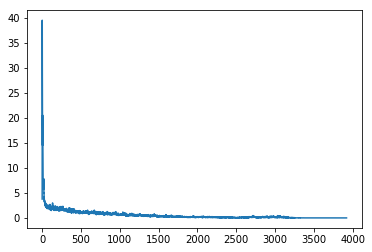

[40/100]


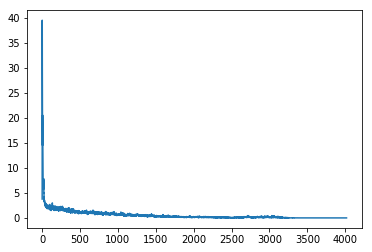

[41/100]


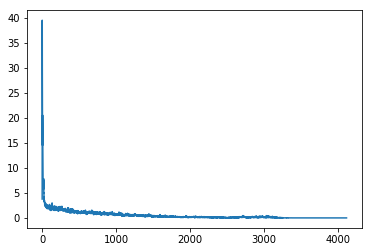

[42/100]


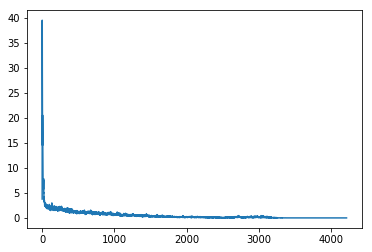

[43/100]


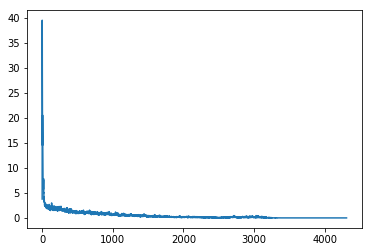

[44/100]


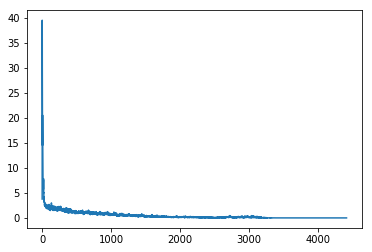

[45/100]


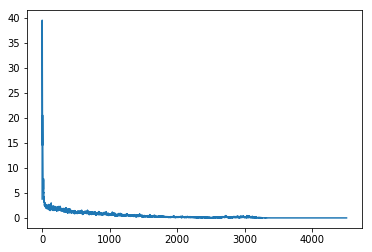

[46/100]


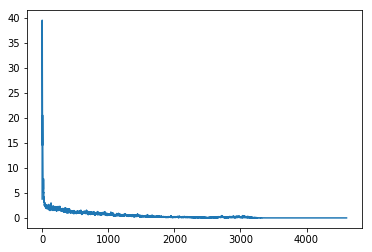

[47/100]


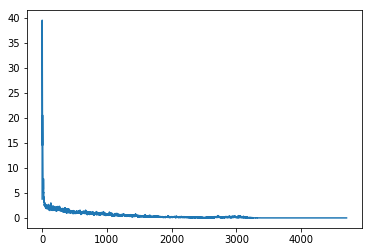

[48/100]


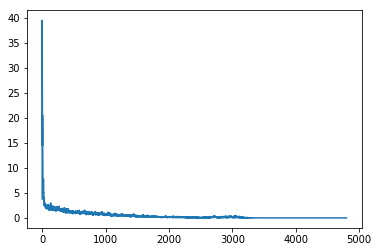

[49/100]


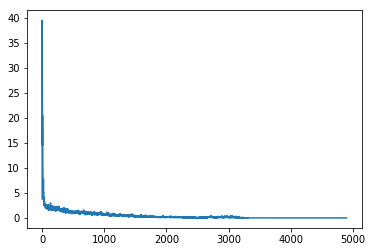

[50/100]


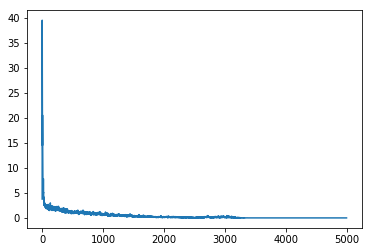

[51/100]


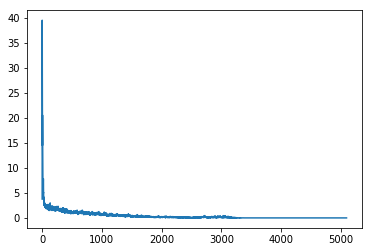

[52/100]


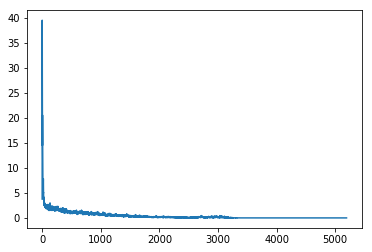

[53/100]


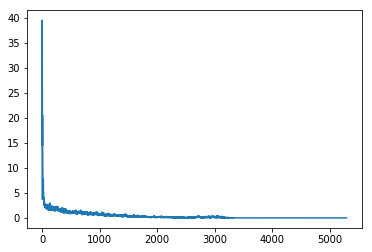

[54/100]


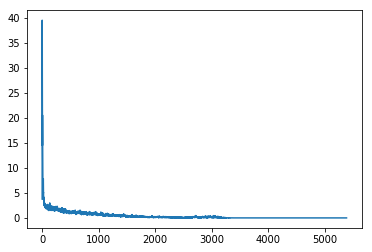

[55/100]


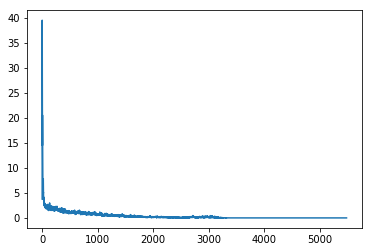

[56/100]


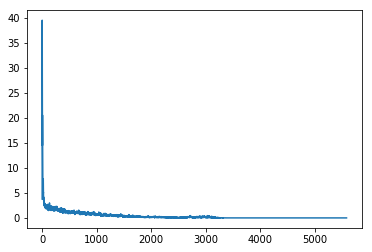

[57/100]


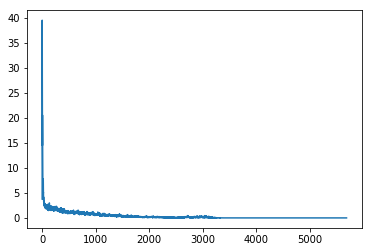

[58/100]


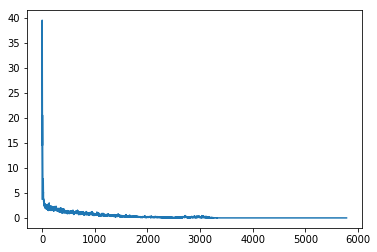

[59/100]


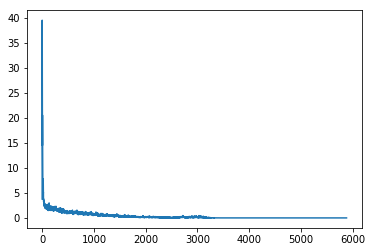

[60/100]


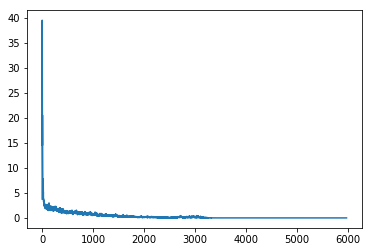

[61/100]


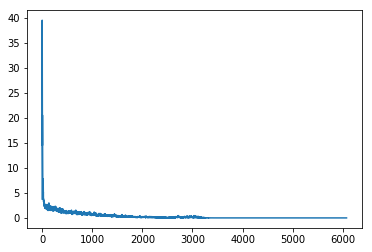

[62/100]


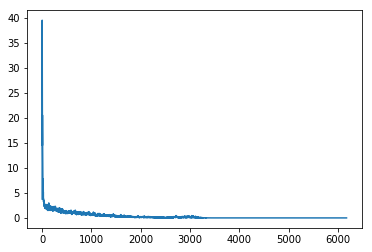

[63/100]


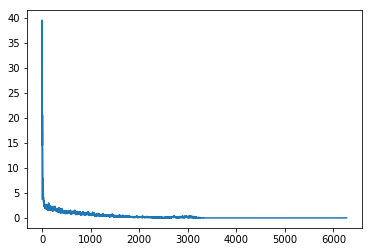

[64/100]


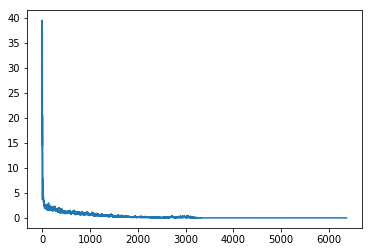

[65/100]


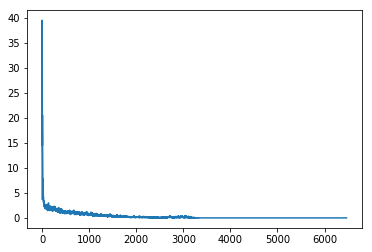

[66/100]


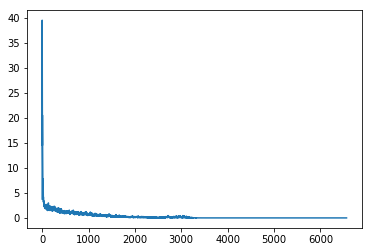

[67/100]


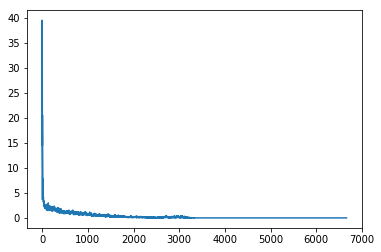

[68/100]


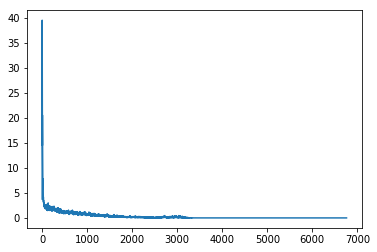

[69/100]


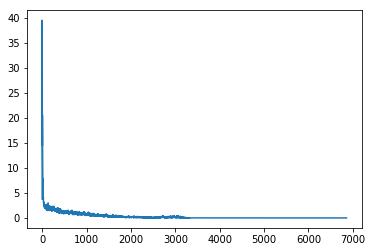

[70/100]


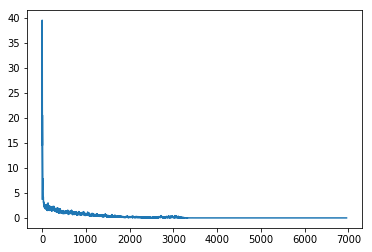

[71/100]


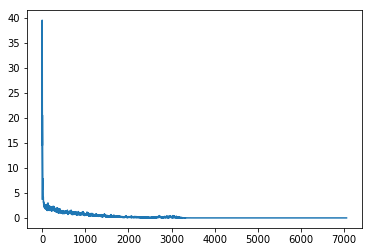

[72/100]


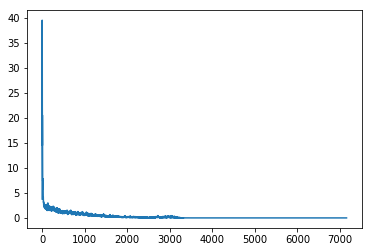

[73/100]


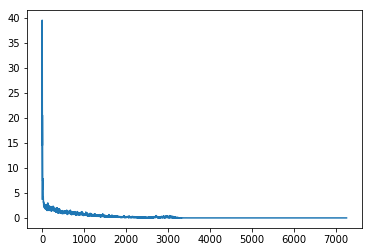

[74/100]


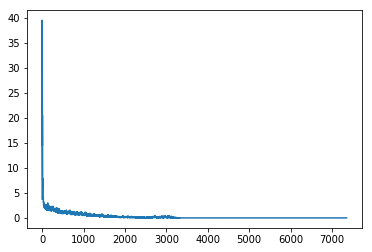

[75/100]


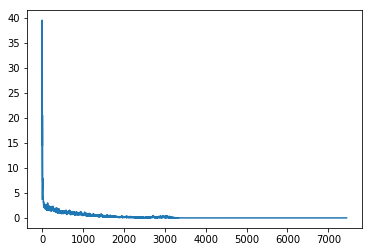

[76/100]


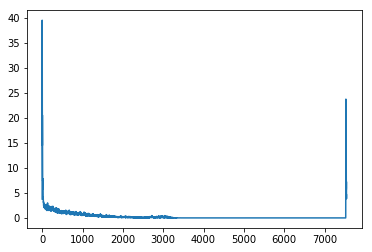

[77/100]


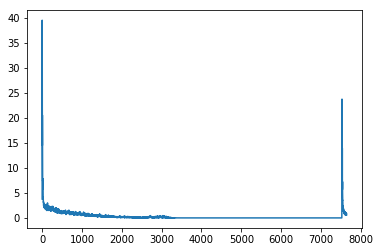

[78/100]


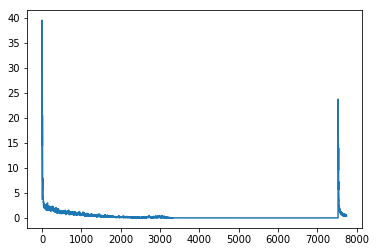

[79/100]


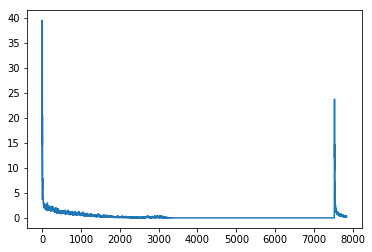

[80/100]


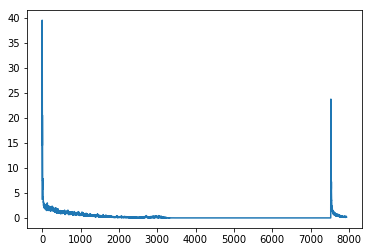

[81/100]


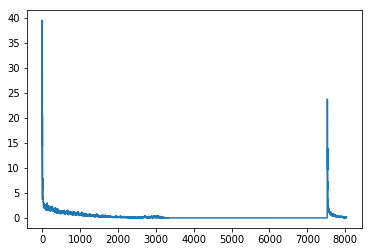

[82/100]


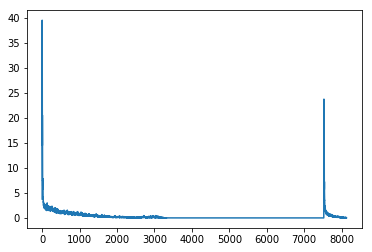

[83/100]


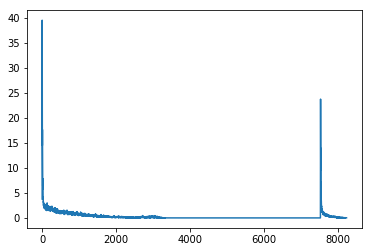

[84/100]


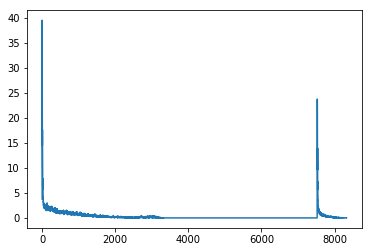

[85/100]


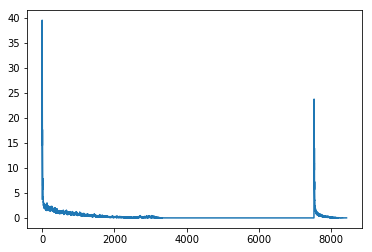

[86/100]


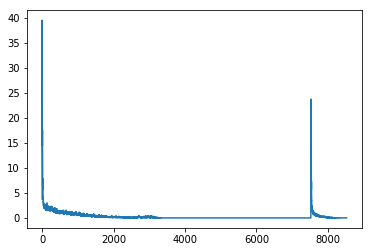

[87/100]


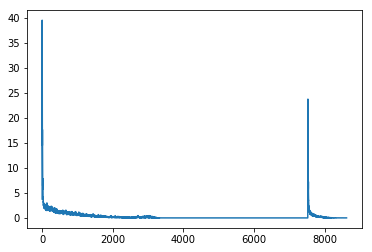

[88/100]


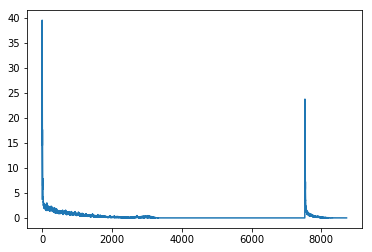

[89/100]


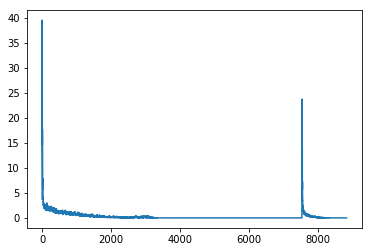

[90/100]


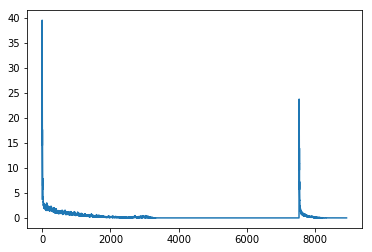

[91/100]


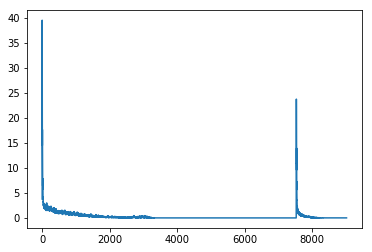

[92/100]


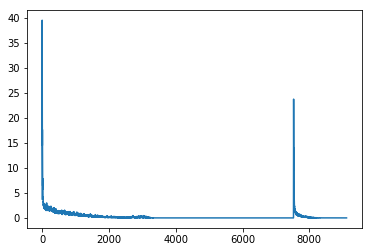

[93/100]


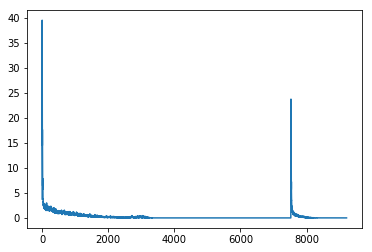

[94/100]


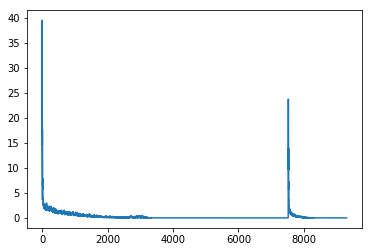

[95/100]


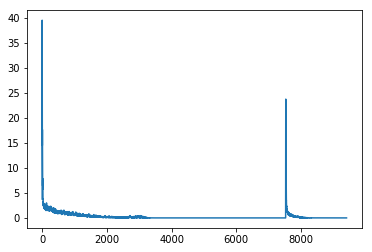

[96/100]


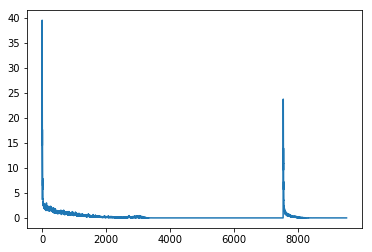

[97/100]


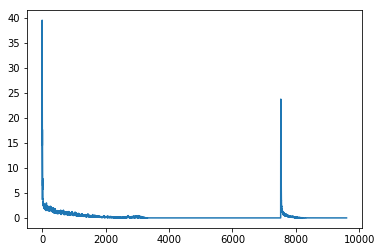

[98/100]


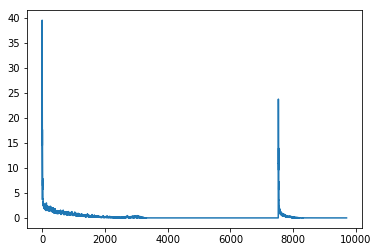

[99/100]


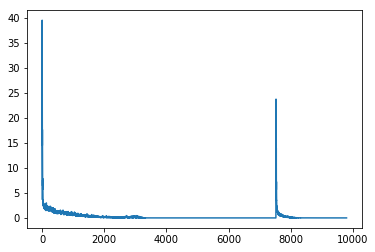

In [11]:
losses = []
for epoch in range(n_epochs):
    shadow_net.train()
    for i, batch in enumerate(shadow_train_loader):

        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)

        shadow_optim.zero_grad()

        outputs = shadow_net(imgs)

        loss = shadow_loss(outputs, labels)
        loss.backward()
        shadow_optim.step()

        losses.append(loss.item())

    print("[%d/%d]" %(epoch, n_epochs))
    plt.plot(losses)
    plt.show()

# Train Attack Model


In [12]:
in_predicts=[]
out_predicts=[]
losses = []

shadow_net=shadow_net
shadow_net.eval()

for epoch in range(n_epochs):

    total = 0
    correct = 0

    train_top = np.empty((0,2))
    out_top = np.empty((0,2))
    for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(shadow_train_loader, shadow_out_loader)):

        if train_imgs.shape[0] != out_imgs.shape[0]: 
            break

        mini_batch_size = train_imgs.shape[0]

        train_imgs, out_imgs = train_imgs.to(device), out_imgs.to(device)

        train_posteriors = F.softmax(shadow_net(train_imgs.detach()), dim=1)

        out_posteriors = F.softmax(shadow_net(out_imgs.detach()), dim=1)




        train_sort, _ = torch.sort(train_posteriors, descending=True)
        train_top_k = train_sort[:,:k].clone().to(device)
        for p in train_top_k:
            in_predicts.append((p.max()).item())
        out_sort, _ = torch.sort(out_posteriors, descending=True)
        out_top_k = out_sort[:,:k].clone().to(device)
        for p in out_top_k:
            out_predicts.append((p.max()).item())

        train_top = np.vstack((train_top,train_top_k[:,:2].cpu().detach().numpy()))
        out_top = np.vstack((out_top, out_top_k[:,:2].cpu().detach().numpy()))


        train_lbl = torch.ones(mini_batch_size).to(device)
        out_lbl = torch.zeros(mini_batch_size).to(device)

        attack_optim.zero_grad()

        train_predictions = torch.squeeze(attack_net(train_top_k))
        out_predictions = torch.squeeze(attack_net(out_top_k))

        loss_train = attack_loss(train_predictions, train_lbl)
        loss_out = attack_loss(out_predictions, out_lbl)

        loss = (loss_train + loss_out) / 2

        loss.backward()
        attack_optim.step()


        correct += (torch.sigmoid(train_predictions)>=0.5).sum().item()
        correct += (torch.sigmoid(out_predictions)<0.5).sum().item()
        total += train_predictions.size(0) + out_predictions.size(0)


        print("[%d/%d][%d/%d] loss = %.2f, accuracy = %.2f" % (epoch, n_epochs, i, len(shadow_train_loader), loss.item(), 100 * correct / total))


[0/100][0/98] loss = 0.69, accuracy = 50.78
[0/100][1/98] loss = 0.69, accuracy = 50.39
[0/100][2/98] loss = 0.69, accuracy = 50.26
[0/100][3/98] loss = 0.69, accuracy = 53.03
[0/100][4/98] loss = 0.69, accuracy = 53.91
[0/100][5/98] loss = 0.69, accuracy = 54.36
[0/100][6/98] loss = 0.69, accuracy = 54.58
[0/100][7/98] loss = 0.69, accuracy = 55.66
[0/100][8/98] loss = 0.69, accuracy = 55.03
[0/100][9/98] loss = 0.69, accuracy = 54.53
[0/100][10/98] loss = 0.69, accuracy = 54.12
[0/100][11/98] loss = 0.69, accuracy = 53.78
[0/100][12/98] loss = 0.69, accuracy = 54.63
[0/100][13/98] loss = 0.69, accuracy = 55.05
[0/100][14/98] loss = 0.69, accuracy = 55.39
[0/100][15/98] loss = 0.69, accuracy = 55.98
[0/100][16/98] loss = 0.69, accuracy = 56.53
[0/100][17/98] loss = 0.69, accuracy = 56.81
[0/100][18/98] loss = 0.69, accuracy = 57.30
[0/100][19/98] loss = 0.69, accuracy = 58.05
[0/100][20/98] loss = 0.69, accuracy = 58.82
[0/100][21/98] loss = 0.69, accuracy = 59.38
[0/100][22/98] loss 

# Train Target Model

[0/100]


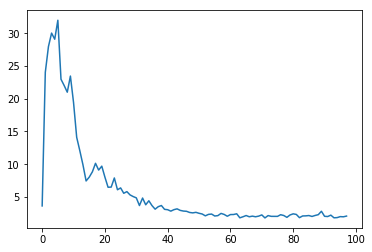

[1/100]


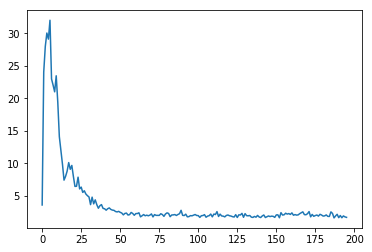

[2/100]


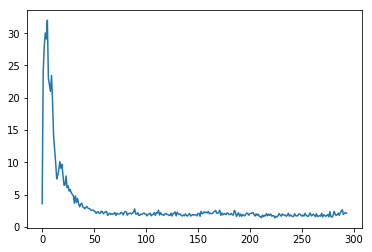

[3/100]


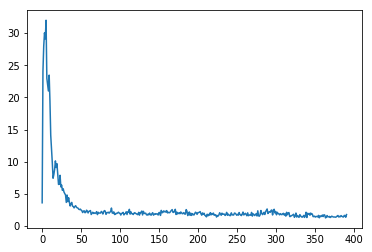

[4/100]


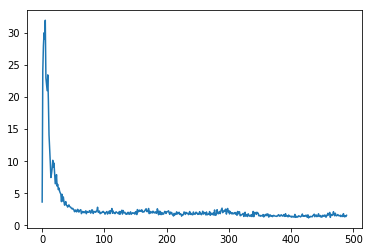

[5/100]


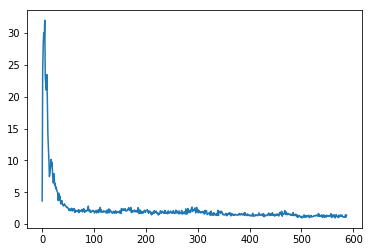

[6/100]


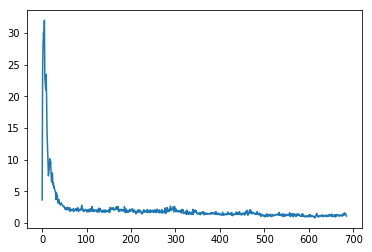

[7/100]


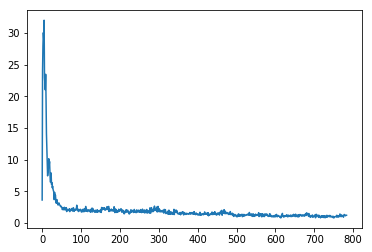

[8/100]


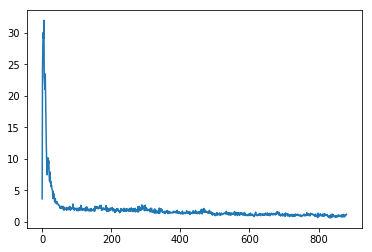

[9/100]


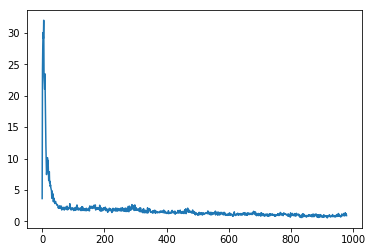

[10/100]


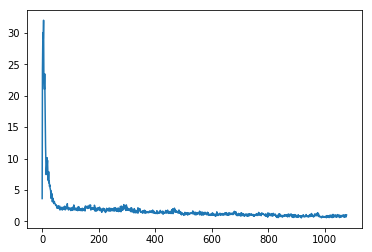

[11/100]


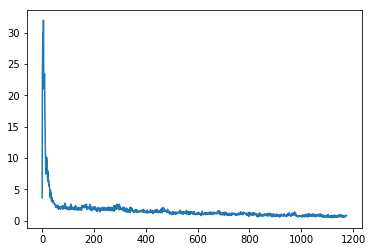

[12/100]


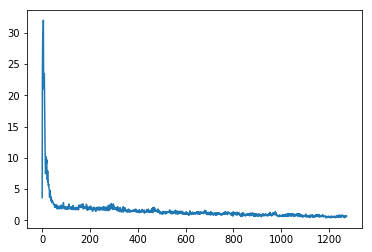

[13/100]


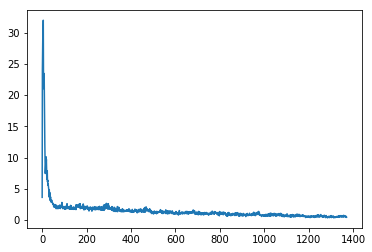

[14/100]


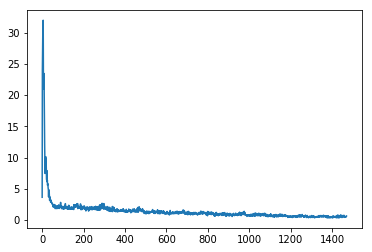

[15/100]


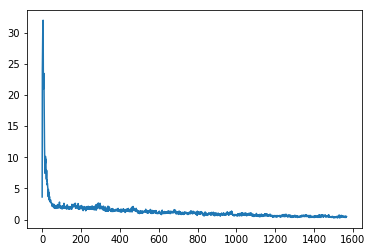

[16/100]


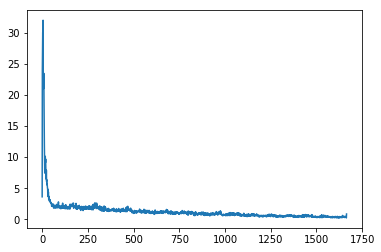

[17/100]


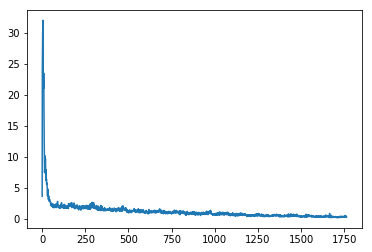

[18/100]


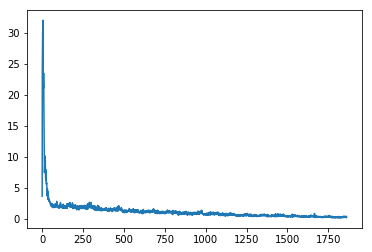

[19/100]


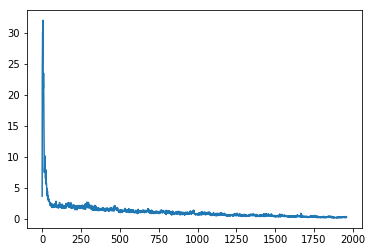

[20/100]


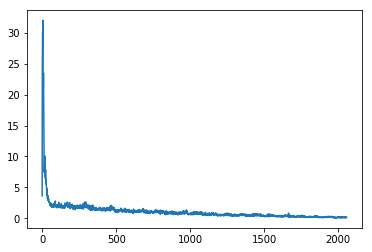

[21/100]


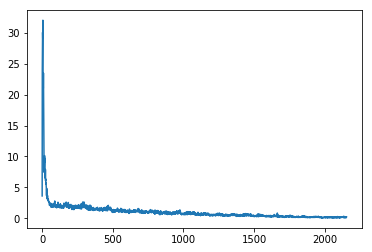

[22/100]


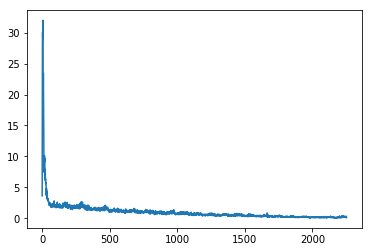

[23/100]


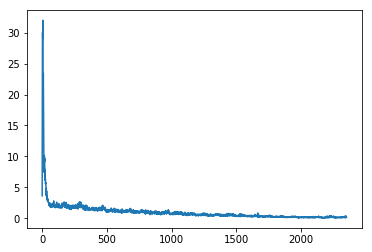

[24/100]


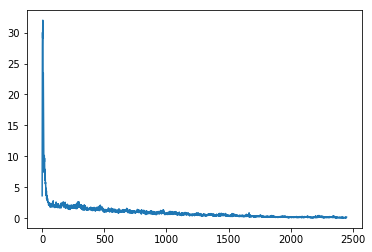

[25/100]


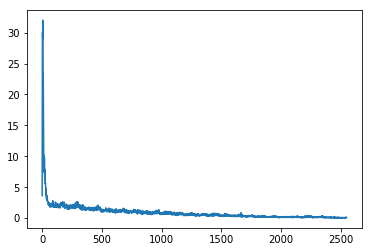

[26/100]


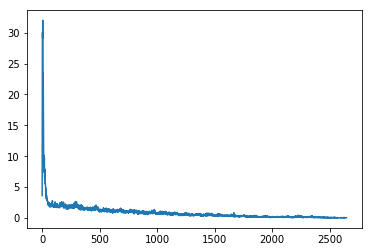

[27/100]


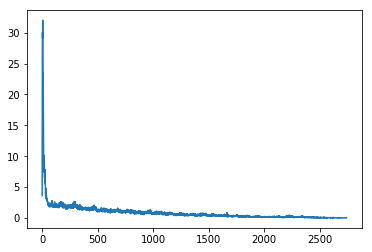

[28/100]


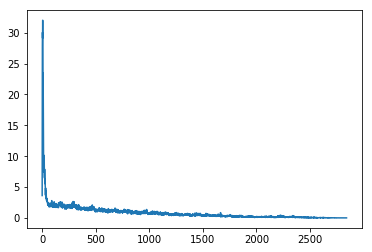

[29/100]


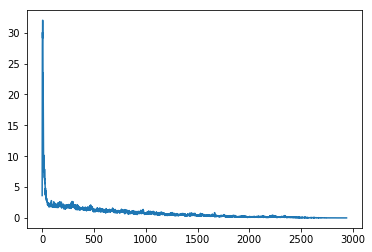

[30/100]


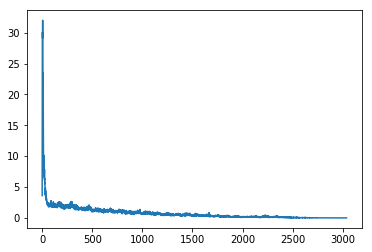

[31/100]


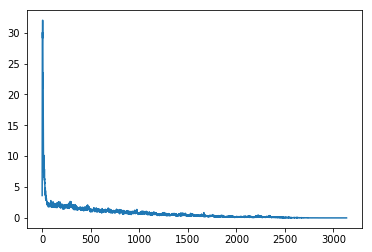

[32/100]


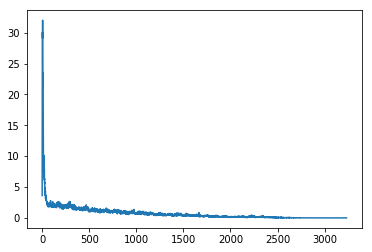

[33/100]


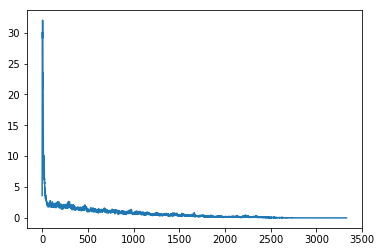

[34/100]


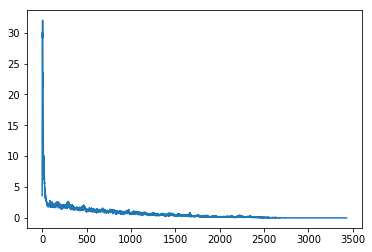

[35/100]


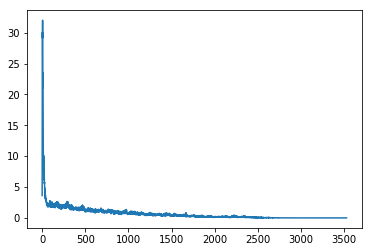

[36/100]


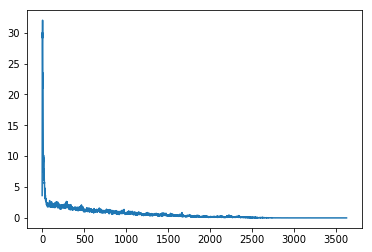

[37/100]


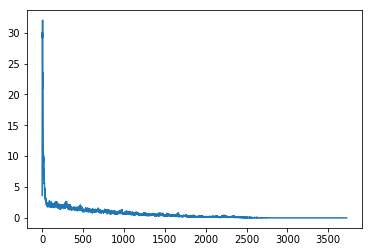

[38/100]


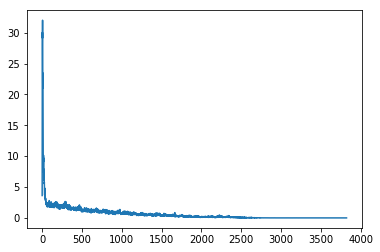

[39/100]


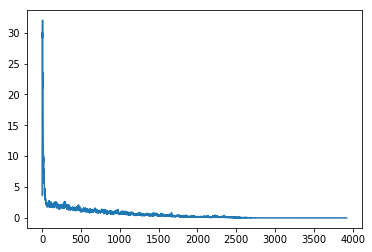

[40/100]


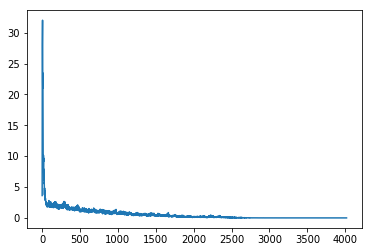

[41/100]


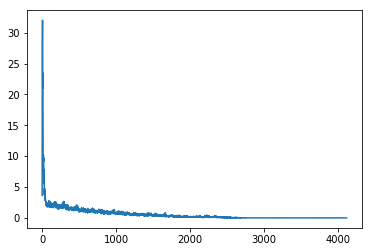

[42/100]


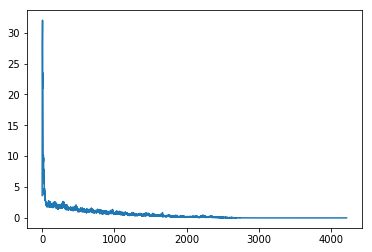

[43/100]


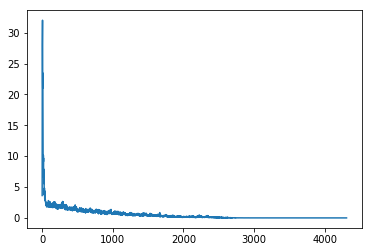

[44/100]


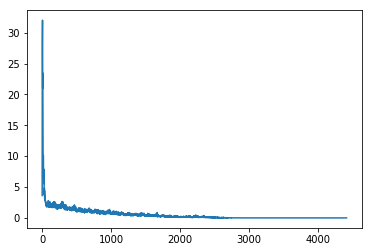

[45/100]


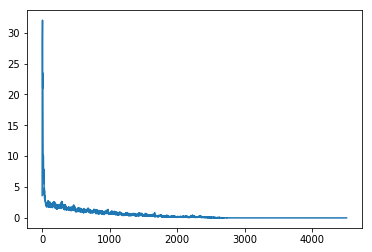

[46/100]


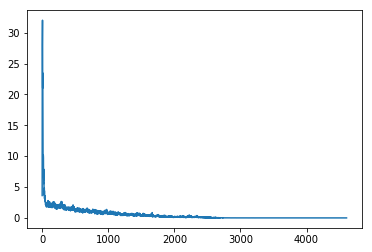

[47/100]


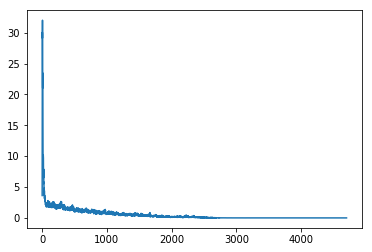

[48/100]


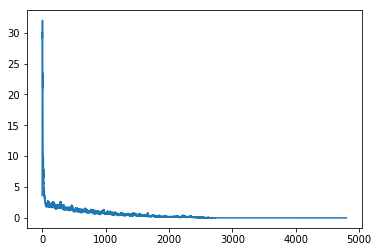

[49/100]


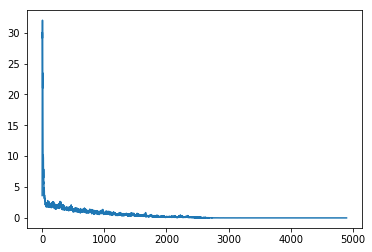

[50/100]


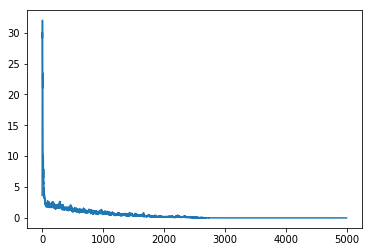

[51/100]


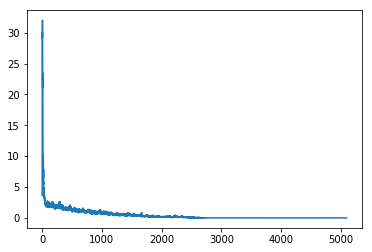

[52/100]


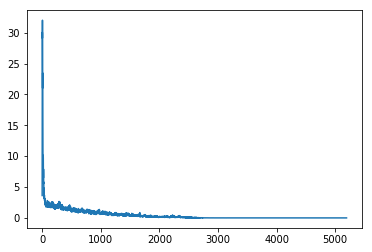

[53/100]


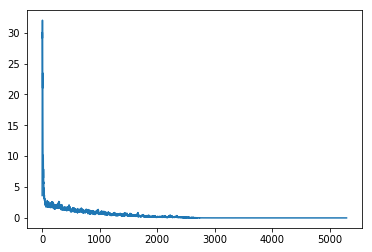

[54/100]


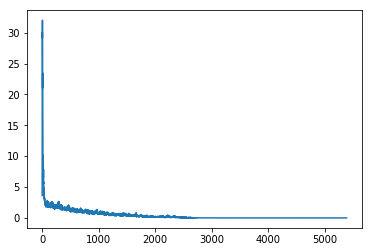

[55/100]


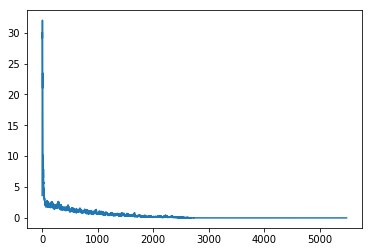

[56/100]


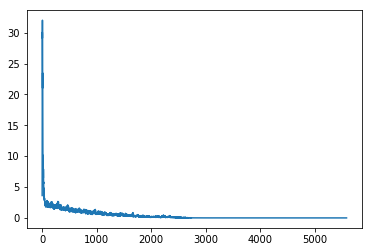

[57/100]


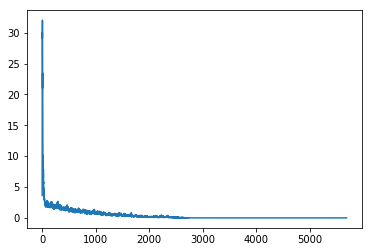

[58/100]


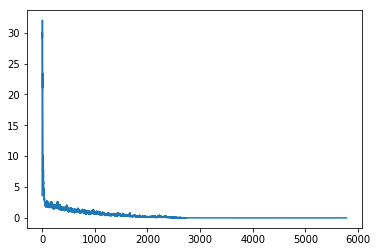

[59/100]


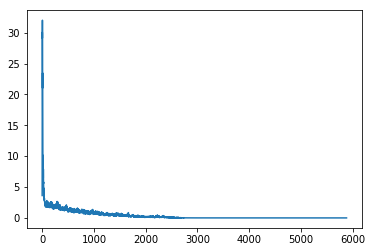

[60/100]


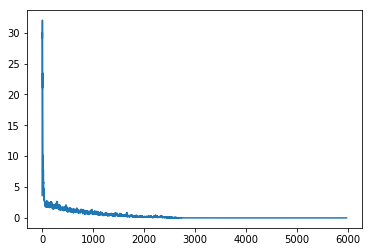

[61/100]


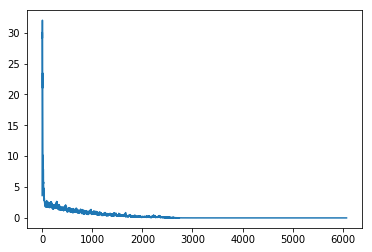

[62/100]


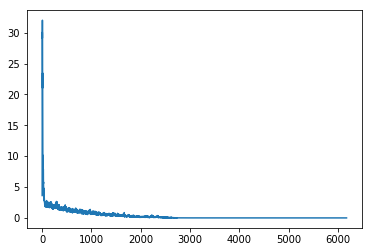

[63/100]


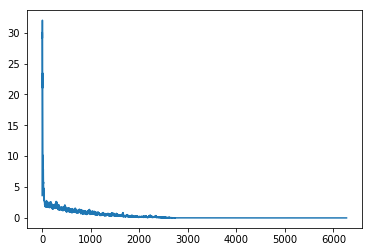

[64/100]


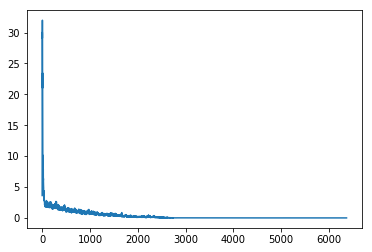

[65/100]


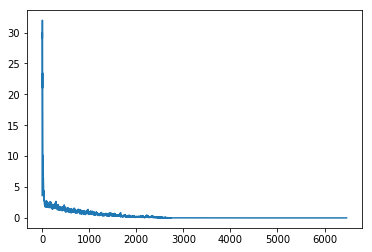

[66/100]


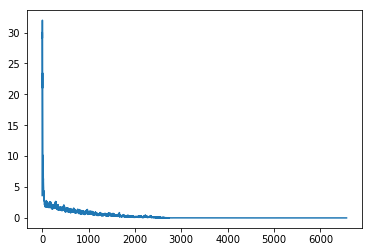

[67/100]


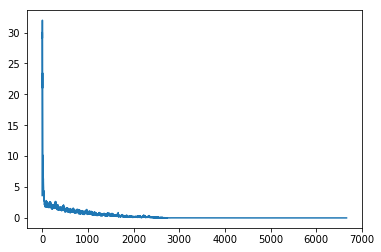

[68/100]


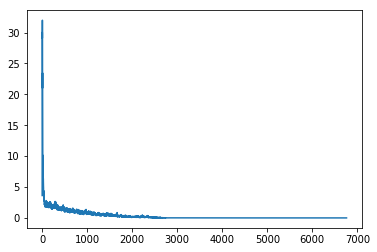

[69/100]


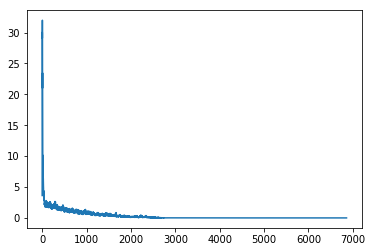

[70/100]


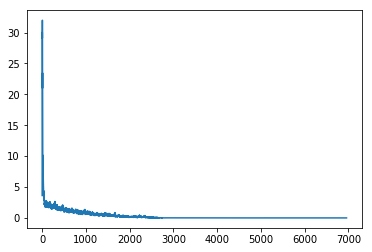

[71/100]


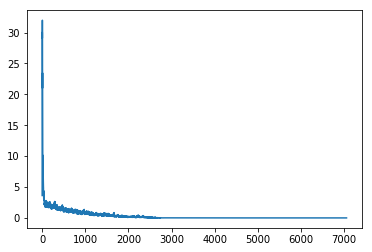

[72/100]


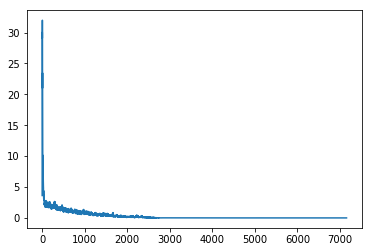

[73/100]


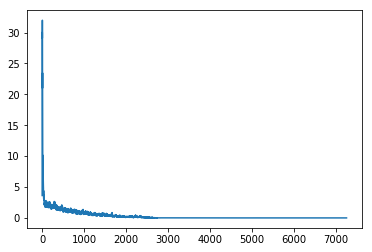

[74/100]


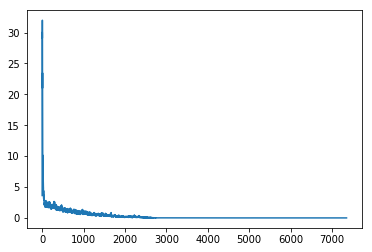

[75/100]


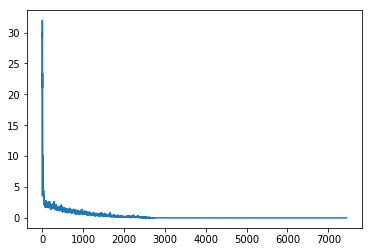

[76/100]


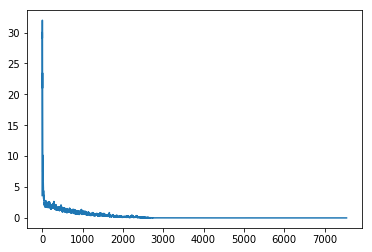

[77/100]


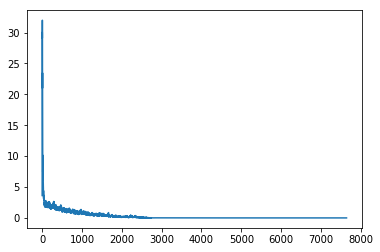

[78/100]


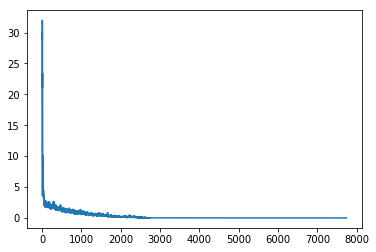

[79/100]


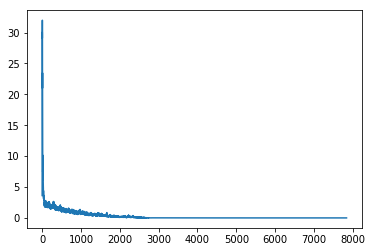

[80/100]


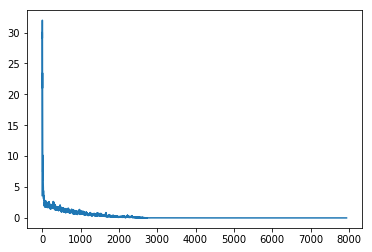

[81/100]


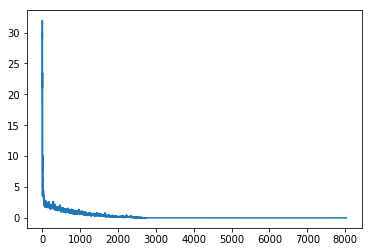

[82/100]


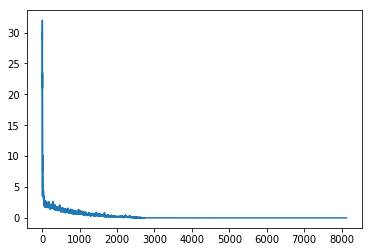

[83/100]


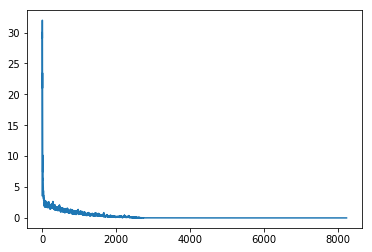

[84/100]


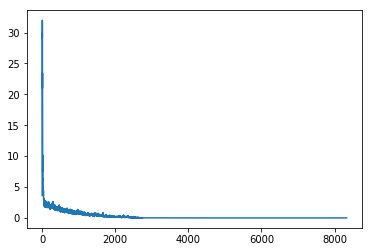

[85/100]


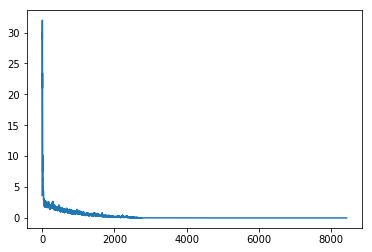

[86/100]


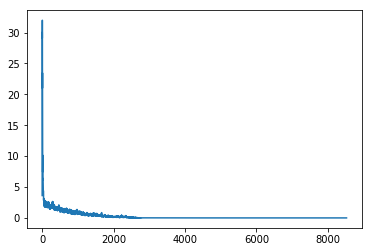

[87/100]


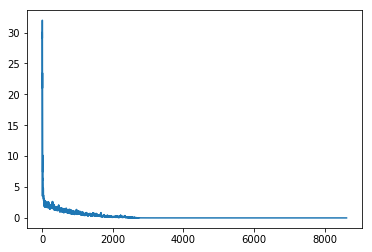

[88/100]


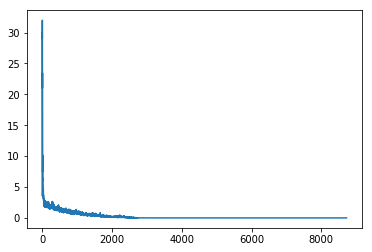

[89/100]


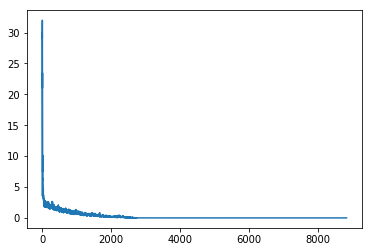

[90/100]


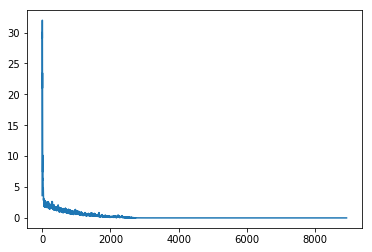

[91/100]


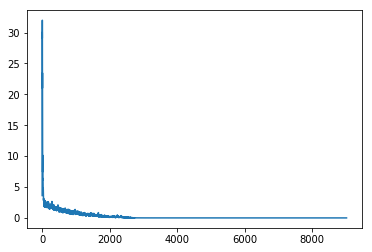

[92/100]


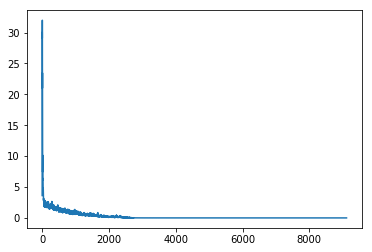

[93/100]


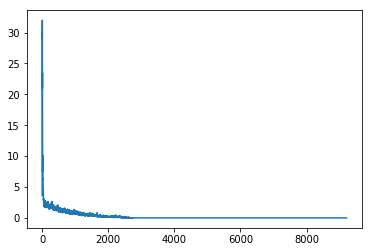

[94/100]


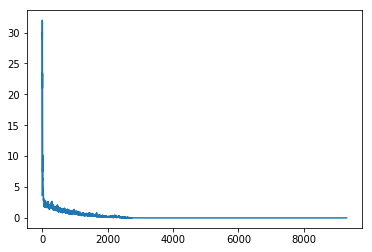

[95/100]


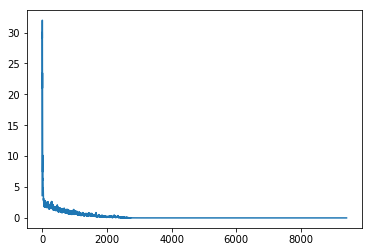

[96/100]


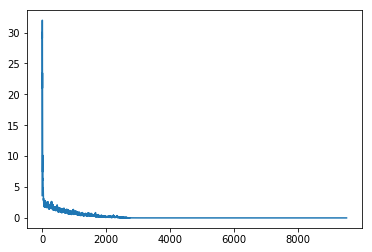

[97/100]


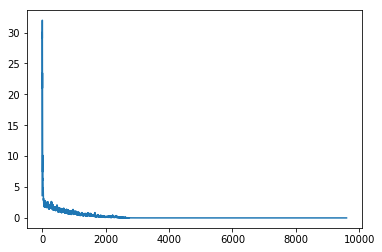

[98/100]


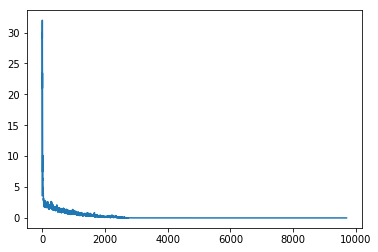

[99/100]


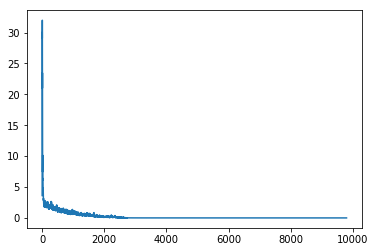

In [13]:
losses = []
for epoch in range(n_epochs):
    target_net.train()
    for i, batch in enumerate(target_train_loader):

        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)

        target_optim.zero_grad()

        outputs = target_net(imgs)

        loss = target_loss(outputs, labels)
        loss.backward()
        target_optim.step()

        losses.append(loss.item())

    print("[%d/%d]" %(epoch, n_epochs))
    plt.plot(losses)
    plt.show()

# Evaluation Of The Attack


In [14]:

in_predicts=[]
out_predicts=[]
losses = []

target_net=target_net
target_net.eval()

attack_net.eval()


precisions = []
recalls = []
accuracies = []

thresholds = np.arange(0.5, 1, 0.005)

total = np.zeros(len(thresholds))
correct = np.zeros(len(thresholds))

true_positives = np.zeros(len(thresholds))
false_positives = np.zeros(len(thresholds))
false_negatives = np.zeros(len(thresholds))   

train_top = np.empty((0,2))
out_top = np.empty((0,2))

for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(target_train_loader, target_out_loader)):


    mini_batch_size = train_imgs.shape[0]
    train_imgs, out_imgs = train_imgs.to(device), out_imgs.to(device)

    
    train_posteriors = F.softmax(target_net(train_imgs.detach()), dim=1)
    out_posteriors = F.softmax(target_net(out_imgs.detach()), dim=1)


    train_sort, _ = torch.sort(train_posteriors, descending=True)
    train_top_k = train_sort[:,:k].clone().to(device)

    out_sort, _ = torch.sort(out_posteriors, descending=True)
    out_top_k = out_sort[:,:k].clone().to(device)

    for p in train_top_k:
        in_predicts.append((p.max()).item())
    for p in out_top_k:
        out_predicts.append((p.max()).item())

    train_top = np.vstack((train_top,train_top_k[:,:2].cpu().detach().numpy()))
    out_top = np.vstack((out_top, out_top_k[:,:2].cpu().detach().numpy()))


    train_lbl = torch.ones(mini_batch_size).to(device)
    out_lbl = torch.zeros(mini_batch_size).to(device)

    train_predictions = F.sigmoid(torch.squeeze(attack_net(train_top_k)))
    out_predictions = F.sigmoid(torch.squeeze(attack_net(out_top_k)))


    for j, t in enumerate(thresholds):
        true_positives[j] += (train_predictions >= t).sum().item()
        false_positives[j] += (out_predictions >= t).sum().item()
        false_negatives[j] += (train_predictions < t).sum().item()

        correct[j] += (train_predictions >= t).sum().item()
        correct[j] += (out_predictions < t).sum().item()
        total[j] += train_predictions.size(0) + out_predictions.size(0)


for j, t in enumerate(thresholds):
    accuracy = 100 * correct[j] / total[j]
    precision = true_positives[j] / (true_positives[j] + false_positives[j]) if true_positives[j] + false_positives[j] != 0 else 0
    recall = true_positives[j] / (true_positives[j] + false_negatives[j]) if true_positives[j] + false_negatives[j] !=0 else 0
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    print("accuracy = %.2f, precision = %.2f, recall = %.2f" % (accuracy, precision, recall))
    break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


accuracy = 70.79, precision = 0.63, recall = 1.00


# Train Accuracy


In [15]:
classes = None
if classes is not None:
      class_correct = np.zeros(10)
      class_total = np.zeros(10)
total = 0
correct = 0
with torch.no_grad():
    target_net.eval()
    for i, (imgs, lbls) in enumerate(target_train_loader):

        imgs, lbls = imgs.to(device), lbls.to(device)

        output = target_net(imgs)

        predicted = output.argmax(dim=1)

        total += imgs.size(0)
        correct += predicted.eq(lbls).sum().item()



accuracy = 100*(correct/total)
print("\nAccuracy = %.2f %%\n\n" % (accuracy) )


Accuracy = 100.00 %




# Testing Accuracy

In [16]:
class_correct = np.zeros(10)
class_total = np.zeros(10)
total = 0
correct = 0
with torch.no_grad():
    target_net.eval()
    for i, (imgs, lbls) in enumerate(testloader):

        imgs, lbls = imgs.to(device), lbls.to(device)

        output = target_net(imgs)

        predicted = output.argmax(dim=1)

        total += imgs.size(0)
        correct += predicted.eq(lbls).sum().item()



accuracy = 100*(correct/total)
print("\nAccuracy = %.2f %%\n\n" % (accuracy) )


Accuracy = 76.12 %




Great! At this point, you must have created a succesfful attack model that can detect whether a datapoint was used in training a target mode or not. 
* A successful attack model is one with a precision/recall higher than 85% -- you are using same architecture and are aware of the data classes

 
 Can you suggest any defense mechanism? If yes, Apply them to your solution and re-evaluate your attack model. How did your defense mecanism affect the accuracy of the target model? How did it affect the recall and precision of the Attack model?